In [78]:
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import numpy as np
import csv

### Free body diagram of the system. 
The shock cords are modeled as a spring, the parachute as a mass attached to a viscous damper with force proportional to the velocity squared, and the rockets as a mass. 

### Setting up the diffy Qs
 We can write two governing differential equations using our favourite equation: $ma-F=0$. $F$ is the sum of all forces on each body (in this case the force of the paracute drag, the force of the shock cords, and gravity) and $a$ is the acceleration of the mass (either the rocket or the parachutes).

<img src="FBD.png" width=500 />  

 We can split the two 2nd order equations into four 1st order equations so that odeint (the numerical solver) can solve them.

$$
\dot{x_p} = y_p,\\ \ \
\dot{x_r} = y_r,\\
\dot{y_r} = \frac{m_r g- k(x_r - x_p)}{m_r}, \\
\dot{y_p} = \frac{m_p g - c {y_p}^2 - k(x_p - x_r)}{m_p}, \\
$$

The constant $c$ is the value of viscous damping. It is easily derived from the drag equation:

$$
F_d=\frac{1}{2} \rho_{air} v^2 C_D A
$$

where $\rho_{air}$ is the density of air, $v^2$ is the velocity of the parachute, $C_D$ is the coeffecient of drag, and $A$ is the effective area. Combining the constant terms (we assume air density is constant during inflation), we are left with:

$$
F_d=cv^2
$$

where

$$
c=\frac{1}{2} \rho_{air} C_D A
$$

Now we can move on to setting up the simulation parameters.

### Setting up the solver (these are what you should edit for a sim)
First select the system properties:

| Parameter | Unit   | Description                                                                                                                      |
|-----------|--------|----------------------------------------------------------------------------------------------------------------------------------|
| mp        | kg     | Mass of the parachute.                                                                                                           |
| ms        | kg     | Mass of the shock cords.                                                                                                         |
| mr        | kg     | Mass of the rocket at the current stage of deployment.                                                                           |
| mn        | kg     | Mass of the parachute including any quick-links etc.                                                                             |
| l_nc      | m      | Length of tether connecting nosecone to parachute bridle (if this is how the rocket is configured). Tether is assumed inelastic. |
| k         | N/m    | Spring constant of the shock cords.                                                                                              |
| rho       | kg/m^3 | Density of the air at deployment altitude.                                                                                       |
| aeff      | m^2    | Planform area of parachute. Subtract any spill hole area.                                                                        |
| cd        | -      | Drag coefficient of the parachute.                                                                                               |

In [79]:
mp   = 0.09
ms   = 0.4
mr   = 11.42
mn   = 2.8
l_nc = 0.6
k    = 6743
rho  = 0.47
aeff = 0.4
cd	 = 1.3

# If this is a drogue parachute with a nosecone attached, set drogue = True
drogue = True

Then set the initial conditions:

| Parameter | Unit   | Description                                                                                                                      |
|-----------|--------|----------------------------------------------------------------------------------------------------------------------------------|
| xr_dot    | m/s    | Speed of rocket at parachute inflation. Value should be positive.                                                                |       
| xp_dot    | m/s    | Speed of parachute at inflation. Assumed to be approximately 0.                                                                  |
| wind      | m/s    | Speed of wind at parachute inflation. Positive values increase load on recovery system.                                          |

In [80]:
xr_dot = 40.0
xp_dot = 0.0
wind   = 30.0

Finally the duration to solve over. Adjust these values to appropriately display the data in the generated graphs.

| Parameter | Unit   | Description                                                                                                                      |
|-----------|--------|----------------------------------------------------------------------------------------------------------------------------------|
| t_start   | s      | Start of the simulation to solve over. Always 0.                                                                |       
| t_end     | s      | End of the simulation time to solve over. Adjust this to display area of interest in graphs. Usually a value of 0.1 to 0.5 is sufficient. For a sanity check, a much longer value can be given in which case the solver should asymptotically converge to shock cord forces that are equal to the gravitational force on the rocket. |
| nt        | -      | Number of data points to plot.                                          |

In [81]:
t_start = 0.0
t_end   = 0.1
nt      = 5000

Now let odeint work some magic... (You don't need to edit anything further)

In [82]:
# More constants for the sim
g  = 9.81       # [m/s^2]   Gravity
xp = 0.0        # [m]   init position is always zero
xr = 0.0        # [m]   init position is always zero

# Calculate the damping coefficent c from the drag equation
c = 0.5*rho*cd*aeff

# Calculate the effective mass of the parachute 1/3 effective mass for shock cord spring
mp_eff = mp + ms/3

# Time vector
t = np.linspace(t_start, t_end, nt)

# Initial conditon vector
y0=[xp, xr, xr_dot, xp_dot] 

# The function defining the right-hand sides (RHS) of the ODEs
def dy_dt(y, t, mp_eff, mr, c, k, g):
    
    # Initial values
    xp, xr, yr, yp = y 

    # Array of RHSs of differential equations
    dydt = [yp, yr, (mr*g - k*(xr-xp))/mr, (mp_eff*g - c*(yp+wind)**2 - k*(xp-xr))/mp_eff]

    return dydt

# Solve the ODEs
sol = odeint(dy_dt, y0, t, args=(mp_eff,mr,c,k,g))  # This gives xp, xr, yr, yp

# Select the solution vectors from the solution
xp = sol[:,0] ; xr = sol[:,1] 
yr = sol[:,2] ; yp = sol[:,3]

 ### Nosecone Inertial Effects
 The nosecone is dragged by the drogue during deployment. First the shock cords go tight due to the drogue, then the slack in tether connecting the nosecone to the drogue is taken up (twice as it passes over the parachute bridle) before the nosecone is finally accelerated. This produces an inertial load that must be included.

In [83]:
if drogue:
  # Find conditions when nosecone tether slack is taken up and goes taut
  indices_taut = np.where(xp < 2*l_nc)[0]
  idx_taut = indices_taut[-1]

  xp_taut = xp[idx_taut]
  xr_taut = xr[idx_taut]
  yp_taut = yp[idx_taut]
  yr_taut = yr[idx_taut]

  # From now on treat the nosecone and parachute mass as one object (since the tether is assumed rigid)
  mp_eff_nc = mp_eff + mn

  # Conservation of momentum to find velocity of combined mass
  yp_eff_nc_dot = yp_taut*(mp_eff/mp_eff_nc)

  # New initial conditon vector for when nosecone tether is taut
  y0=[xp_taut, xr_taut, yr_taut, yp_eff_nc_dot] 

  # New time vector that starts when the tether goes taut
  t_taut = t[idx_taut+1:]

  # Solve differentials again with new initial conditions and masses 
  sol = odeint(dy_dt, y0, t_taut, args=(mp_eff_nc,mr,c,k,g))
  xp_taut = sol[:,0] ; xr_taut = sol[:,1] 
  yr_taut = sol[:,2] ; yp_taut = sol[:,3]

  # Remove values from previous solutions that didn't account for nosecone
  pre_taut = len(indices_taut)
  xp = xp[:pre_taut] ; xr = xr[:pre_taut]
  yp = yp[:pre_taut] ; yr = yr[:pre_taut]

  # Concatenate new nosecone corrected values to these
  xr = np.concatenate((xr, xr_taut)) ; xp = np.concatenate((xp, xp_taut))
  yr = np.concatenate((yr, yr_taut)) ; yp = np.concatenate((yp, yp_taut))


### Forces on the shock cords and shroud lines
These are computed using the positions of the masses, spring constant of the shock cords, and the drag due to parachute velocity.

In [84]:
# Take derivative of velocity of parachute to get acceleration
ap = np.diff(yp) # yp is the derivative of xp (position of parachute) 

# Tension in the shock cords [N]: F = kx
shock_cord_tension = k*(xr-xp) 

# Force on the bridle due to shroud lines is: F = inertial load + drag load
bridle_shroud_tension = (mp-ms)*ap + c*(wind + yp[:-1])**2

Then we do some plotting.

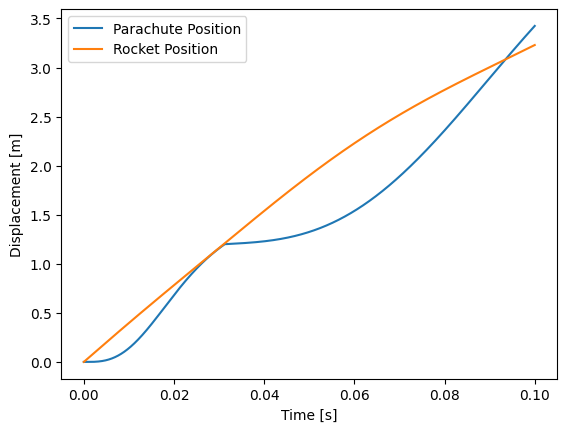

In [85]:
plt.close(); plt.figure()

plt.plot(t, xp, label='Parachute Position')
plt.plot(t, xr, label='Rocket Position')
plt.xlabel('Time [s]')
plt.ylabel('Displacement [m]')
plt.savefig("disp-vs-t.png")

plt.legend()

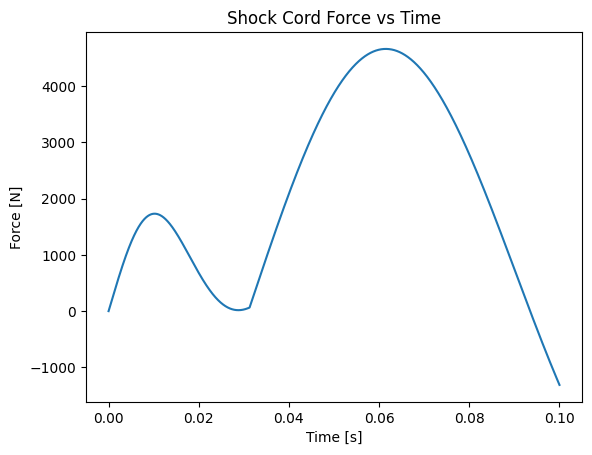

In [86]:
plt.close(); plt.figure()

plt.plot(t, shock_cord_tension,label='Force on shock cords')
plt.title('Shock Cord Force vs Time')
plt.xlabel('Time [s]')
plt.ylabel('Force [N]')
plt.savefig('shockcord-force-vs-time.png')

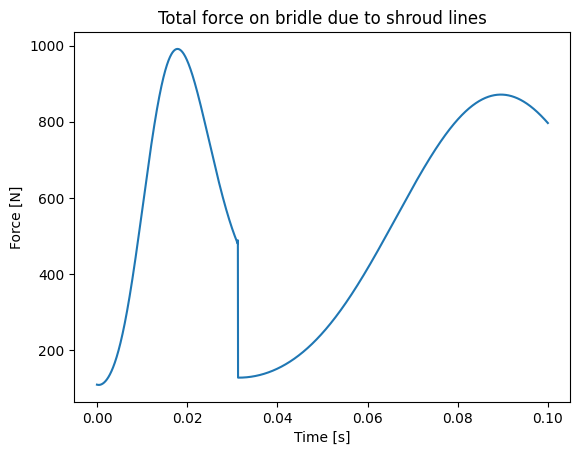

In [87]:
plt.close(); plt.figure()

plt.plot(t[:-1], bridle_shroud_tension)
plt.title('Total force on bridle due to shroud lines')
plt.xlabel('Time [s]')
plt.ylabel('Force [N]')
plt.savefig('bridle-shroud-force-vs-time.png')

### Results for your Documentation
Copy and paste these results into your documentation. You do have documentation right? The graphs are also automatically saved as .png files in the same directory as this notebook.

In [88]:
print("Using the following solver parameters:\n")

print(f"{'Rocket Mass:':<30} {mr:>6.3f} \t[kg]")
print(f"{'Parachute Mass:':<30} {mp:>6.3f} \t[kg]")
print(f"{'Shock Cord Mass:':<30} {ms:>6.3f} \t[kg]")
print(f"{'Shock Cord k:':<30} {k:>6.0f} \t[N/m]")
print(f"{'Tether Length:':<30} {l_nc:>6.2f} \t[m]")
print(f"{'Air Density:':<30} {rho:>6.2f} \t[kg/m^3]")
print(f"{'Wind Speed:':<30} {wind:>6.1f} \t[m/s]")
print(f"{'Drag Coefficient:':<30} {cd:>6.3f} \t[]")
print(f"{'Effective Area:':<30} {aeff:>6.2f} \t[m^2]")

print(f"{'Rocket velocity:':<30} {xr_dot:>6.2f} \t[m/s]")
print(f"{'Parachute velocity:':<30} {xp_dot:>6.2f} \t[m/s]")

print("\nProduced the following results:\n")
print(f"{'Parachute Damping Coeff:':<30} {c:>6.2f} \t[N/m/s]")
print(f"{'Maximum Shock Cord Tension:':<30} {max(shock_cord_tension):>6.0f} \t[N]")
print(f"{'Maximum Bridle Force:':<30} {max(shroud_line_tension):>6.0f} \t[N]")
print(f"{'Maximum Rocket G load:':<30} {((max(shock_cord_tension)/mr)/g):>6.2f} \t[G]")

print("\nExported to load_data.csv")
print("Columns: time [s], shock cord tension [N], shroud line tension [N]")

with open('load_data.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(zip(t, shock_cord_tension, bridle_shroud_tension))

Using the following solver parameters:

Rocket Mass:                    11.42 	[kg]
Parachute Mass:                  0.09 	[kg]
Shock Cord Mass:                 0.40 	[kg]
Shock Cord k:                    6743 	[N/m]
Tether Length:                   0.60 	[m]
Air Density:                     0.47 	[kg/m^3]
Wind Speed:                      30.0 	[m/s]
Drag Coefficient:                1.30 	[]
Effective Area:                  0.40 	[m^2]
Rocket velocity:                40.00 	[m/s]
Parachute velocity:              0.00 	[m/s]

Produced the following results:

Parachute Damping Coeff:         0.12 	[N/m/s]
Maximum Shock Cord Tension:      4664 	[N]
Maximum Shroud Line Tension:      991 	[N]
Maximum Rocket G load:          41.63 	[G]

Exported to load_data.csv
Columns: time [s], shock cord tension [N], shroud line tension [N]


### Comparing with Working Model 2D
Originally the team used the following Working Model 2d simulation which is outlined in the Xenia-1 final report.

<img src="WorkingModel.png" width=500 />  

This produced maximum loads that were approximately 5% higher than this solver. There were some slight differences in the sim setup due to the way that Working Model works so that may account for these differences.  

Since Working Model is clunky, old, closed source, and requires a license to use, this notebook was created as an open source alternative that is more extensible. I hope you enjoy - JJ.